<a href="https://colab.research.google.com/github/showayamada/CategorizeNN/blob/main/%E3%82%AB%E3%83%86%E3%82%B4%E3%83%AA%E5%88%86%E9%A1%9E%E5%99%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# カテゴリ分類器（他クラス分類）
python + scikit-learnで実装する。
analyzerとして、janome、
vectorizerとして、TF-IDF vectrizerを使用する


*   教師データ：実際の家計簿アプリの履歴100件、クレジットカード利用明細（過去6か月）

*   テストデータ：同上　20件(抜粋)

* 学習モデル：Random Forest



アルゴリズムについて

1, 元データからn個の決定木を生成する

2, データ集合からn個の決定木を生成する

3, p個の特徴量からm個の特徴量をランダムに選ぶ

4, n個の決定木の多数決を最終予測とする

In [1]:
!pip install janome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 97.8 MB/s eta 0:00:00


In [2]:
# 使用するパッケージ
import csv
import pandas as pd
import numpy as np
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [3]:
# データの読み込み
raw_data = pd.read_csv("train.csv")
raw_test_data = pd.read_csv("test.csv")
print(raw_data)
print(raw_test_data)

                   支払先     支払金額  カテゴリID
0    etc sapporominami    910.0       7
1                  bag  10510.0       8
2                 milk    200.0       1
3    convenience store   1608.0       1
4    convenience store   1288.0       1
..                 ...      ...     ...
139              eneos    623.0       7
140           zozotown   7140.0       8
141   rakuten pay noma   3520.0       8
142          skyticket  26680.0       6
143             sekoma    399.0       1

[144 rows x 3 columns]
                  支払先   支払金額
0          etc kunimi    870
1                milk    200
2   convenience store   1608
3                rent  50000
4               water   5000
5              ticket   7000
6              kitaka   1490
7           chocolate    500
8       sumika ticket   8000
9    oneokrock ticket  10000
10       seven eleven    300
11        family mart    500
12           any café   2000
13              pizza   3000
14           zozotown   5000
15          mini stop    300
16 

vectorizerに渡すanalyzerの定義

In [4]:
# 名詞と固有名詞の形態素を残す
COLLECTABLES = [
    '名詞',
    '固有名詞'
]

def analyzer(text):
    # 与えられたテキストを tokenize する
    t = Tokenizer()
    tokens = t.tokenize(text)

    # 重複を削除するために、一度 dict に入れて list に変換
    words_dict = {}
    for token in tokens:
        # janome がカンマ区切りで解析結果を渡してくるので切り離して名詞と固有名詞だけ残す
        if token.part_of_speech.split(',')[0] in COLLECTABLES:
            words_dict[token.surface] = True

    # リストに変換
    return list(words_dict.keys())


In [5]:
# vectorizer を定義
# min/max_df はパラメータなので、精度が出なければ調整する
vectorizer = TfidfVectorizer(analyzer=analyzer, min_df=1, max_df=40)

# raw_data には [{'支払先': 'Amazon Prime', '支払金額': 1000}, ...]
# という形式のデータが入っているとする
# ここから支払先だけとりだして、リストにする
corpus = [x['支払先'] for x in raw_data.to_dict('records')]

# 支払先のリストをベクトル化する
# sparse matrix で返ってくるが、後で支払金額とくっつけて 1つの特徴ベクトルにするので、
# array型に変換しておく
vec_for_shop = vectorizer.fit_transform(corpus).toarray()


In [6]:
x = []
y = []
for d, v in zip(raw_data.to_dict('records'), vec_for_shop):
    # 入力ベクトルは、先程ベクトル化した支払先と、支払金額
    e = list(v) + [float(d['支払金額'])]
    x.append(e)

    # y にはカテゴリID を詰め込む
    y.append(int(d['カテゴリID']))

print(x)
print(y)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6511256170001847, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7589699802272345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 910.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10510.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [7]:
# 欠損値の確認
print(pd.DataFrame(x).isnull().sum())

# 欠損値の補完
imputer = SimpleImputer(strategy='mean')
x_imputed = imputer.fit_transform(x)


0     0
1     0
2     0
3     0
4     0
     ..
85    0
86    0
87    0
88    0
89    1
Length: 90, dtype: int64


In [8]:
forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(x_imputed, y)

RandomForestClassifier(random_state=1)

In [9]:
# 教師データと同様の変換
test_data = [x['支払先'] for x in raw_test_data.to_dict('records')]
test_data_payment = vectorizer.transform(test_data).toarray()
fv_test = []
for d, v in zip(raw_test_data.to_dict('records'), test_data_payment):
    e = list(v) + [float(d['支払金額'])]
    fv_test.append(e)

# 学習済みの forest を使ってカテゴリを予測
prediction = forest.predict(fv_test)

print(prediction)

[7 1 1 2 3 6 1 1 6 6 1 1 1 1 8 1 6 6 1]


カテゴリ対応表

-------------------------------
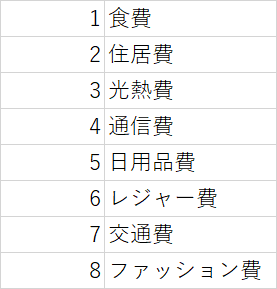

カテゴリは普段使用しているアプリを参照しています。

### 評価
同じワードが含まれているは、上手く分類できた。

教師データにないワードを送った場合は、支払金額が優先されて、分類されているような気がした。

学習させる教師データが少ないと、精度が足りないことが分かった。

交通費に学習されているデータは、kitakaであったり、idemituなどガソリンスタンド名であったり、したが、taxiなど全く新しいワードには案の乗対応できなかった。

精度を高めるためには、ワードを網羅的に学習させるために、大きい教師データが必要であると考えられる。


しかし、
個人使用の範囲内であれば、そこまで普段と違う使い方をしないので、実用可能かと考えた。
